In [1]:
include("../CovarianceFunctions/CovarianceFunctions.jl")
include("./MCMC.jl")

emcee_Run

In [2]:
using LinearAlgebra
using Logging
using PyPlot
using Distributions
using KernelDensity
using ReverseDiff
using StatsBase

In [3]:
## PDEs type
abstract type AbstractPDEs end
struct NonlinElliptic1d{Tα,Tm,TΩ} <: AbstractPDEs
    # eqn: -Δu + α*u^m = f in [Ω[1],Ω[2]]
    α::Tα
    m::Tm
    Ω::TΩ
    bdy::Function
    rhs::Function
end


## Sample points
function sample_points_rdm(eqn::NonlinElliptic1d, N_domain)
    Ω = eqn.Ω
    xl = Ω[1]
    xr = Ω[2]  

    X_domain = rand(Float64,(N_domain, 1))*(xr-xl) + xl
    X_boundary = [xl,xr]

    return X_domain, X_boundary
end
function sample_points_grid(eqn::NonlinElliptic1d, h_in)
    Ω = eqn.Ω
    xl = Ω[1]
    xr = Ω[2]
   
    X_domain = [x for x in  xl + h_in:h_in:xr-h_in]
    X_boundary = [xl,xr]
    return X_domain, X_boundary
end


## Algorithms
# assemby Gram matrices
function get_Gram_matrices(eqn::NonlinElliptic1d, cov::AbstractCovarianceFunction, X_domain, X_boundary)
    
    d = 1
    N_domain = size(X_domain)[1]
    N_boundary = size(X_boundary)[1]

    Δδ_coefs = -1.0

    meas_δ_bd = [PointMeasurement{d}(SVector{d,Float64}(X_boundary[i])) for i = 1:N_boundary]
    meas_δ_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[i])) for i = 1:N_domain]
    meas_Δδ = [ΔδPointMeasurement{Float64,d}(SVector{d,Float64}(X_domain[i]), Δδ_coefs, 0.0) for i = 1:N_domain]

    measurements = Vector{Vector{<:AbstractPointMeasurement}}(undef,3)
    measurements[1] = meas_δ_bd; measurements[2] = meas_δ_int; measurements[3] = meas_Δδ

    Theta_big = zeros(2*N_domain+N_boundary,2*N_domain+N_boundary)
    cov(Theta_big, reduce(vcat,measurements))
    return Theta_big
end

function get_Gram_matrices(eqn::NonlinElliptic1d, cov::AbstractCovarianceFunction, X_domain, X_boundary, sol_now)

    d = 1
    N_domain = size(X_domain)[1]
    N_boundary = size(X_boundary)[1]
    Δδ_coefs = -1.0
    δ_coefs_int = eqn.α*eqn.m*(sol_now.^(eqn.m-1)) 

    # get linearized PDEs correponding measurements
    meas_δ = [PointMeasurement{d}(SVector{d,Float64}(X_boundary[i])) for i = 1:N_boundary]
    meas_Δδ = [ΔδPointMeasurement{Float64,d}(SVector{d,Float64}(X_domain[i]), Δδ_coefs, δ_coefs_int[i]) for i = 1:N_domain]
    meas_test_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[i])) for i = 1:N_domain]

    Theta_train = zeros(N_domain+N_boundary,N_domain+N_boundary)

    measurements = Vector{Vector{<:AbstractPointMeasurement}}(undef,2)
    measurements[1] = meas_δ; measurements[2] = meas_Δδ
    cov(Theta_train, reduce(vcat,measurements))
    
    Theta_test = zeros(N_domain,N_domain+N_boundary)

    cov(Theta_test, meas_test_int, reduce(vcat,measurements))
    return Theta_train, Theta_test
end
function  get_initial_covariance(cov::AbstractCovarianceFunction, X_domain, X_boundary)
    d = 1
    N_domain = size(X_domain)[1]
    N_boundary = size(X_boundary)[1]
    meas_δ_bd = [PointMeasurement{d}(SVector{d,Float64}(X_boundary[i])) for i = 1:N_boundary]
    meas_δ_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[i])) for i = 1:N_domain]
    Theta_initial = zeros(N_domain+N_boundary,N_domain+N_boundary)
    measurements = Vector{Vector{<:AbstractPointMeasurement}}(undef,2)
    measurements[1] = meas_δ_bd; measurements[2] = meas_δ_int
    cov(Theta_initial, reduce(vcat,measurements))
    return Theta_initial
end
function  get_initial_covariance(cov::AbstractCovarianceFunction, X_domain)
    d = 1
    N_domain = size(X_domain)[1]

    meas_δ_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[i])) for i = 1:N_domain]

    Theta_initial = zeros(N_domain,N_domain)
    cov(Theta_initial, meas_δ_int)
    return Theta_initial
end


# Kalman-Laplace Approximation
function KalmanLaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps; nugget = 1e-14)
    N_domain = size(X_domain)[1]
    N_boundary = size(X_boundary)[1]

    # get the rhs and bdy data
    # rhs = [eqn.rhs(X_domain[i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    # bdy = [eqn.bdy(X_boundary[i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)

    rhs = [eqn.rhs(X_domain[i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)

    Theta_train = zeros(N_domain+N_boundary, N_domain+N_boundary) 
    Theta_test = zeros(N_domain,N_domain+N_boundary)

    v = sol_init
    rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
    noise_cov = diagm(vcat([noise_var_bd for _ in 1:N_boundary], [noise_var_int for _ in 1:N_domain]))
    for _ in 1:GNsteps
        Theta_train, Theta_test = get_Gram_matrices(eqn, cov, X_domain, X_boundary, v)
        rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
        v = Theta_test*(((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\rhs_now)
    end

    MAP = v
    Cov_init = get_initial_covariance(cov, X_domain) # only consider UQ of domain pts
    Cov_posterior = Cov_init .- Theta_test*(((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\Theta_test')
    approx_rkhs_norm2 = rhs_now'* (((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\rhs_now)
    return MAP, Cov_posterior, approx_rkhs_norm2
end 


function log_post_GP_PDE(eqn, cov, X_domain, X_boundary; nugget = 1e-14)

    N_domain = size(X_domain)[1]
    N_boundary = size(X_boundary)[1]

    # get the rhs and bdy data
    rhs = [eqn.rhs(X_domain[i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)
    Theta_big = zeros(2*N_domain+N_boundary, 2*N_domain+N_boundary)
    Theta_big = get_Gram_matrices(eqn, cov, X_domain, X_boundary)
    U = cholesky(Theta_big+nugget*diagm(diag(Theta_big))).U  #Theta = U'*U

    function d_log_post(z)
        Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
        tmp = U\(U'\Z)
        return -0.5*Z'*tmp, -tmp[N_boundary+1:N_boundary+N_domain] + eqn.α*eqn.m*(z.^(eqn.m-1)).*tmp[N_boundary+N_domain+1:end]
    end
    return d_log_post
end


function hessian_log_post_GP_PDE(eqn, cov, X_domain, X_boundary; nugget = 1e-9)
    N_domain = size(X_domain)[1]
    N_boundary = size(X_boundary)[1]

    # get the rhs and bdy data
    rhs = [eqn.rhs(X_domain[i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)
    Theta_big = zeros(2*N_domain+N_boundary, 2*N_domain+N_boundary)
    Theta_big = get_Gram_matrices(eqn, cov, X_domain, X_boundary)
    inv_Theta_big = inv(Theta_big + nugget*diagm(diag(Theta_big)))
    function log_post(z)
        Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
        return -0.5*Z'*inv_Theta_big*Z
    end
                                                                
    function hessian_log_post(z)
        Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
        grad_Z = vcat(zeros(N_boundary,N_domain), Matrix(1.0*I,N_domain,N_domain), -eqn.α*eqn.m*diagm(z.^(eqn.m-1)))
        hess = grad_Z'*(Theta_big\grad_Z)
        for i = 1:N_domain
            for j = 1:2*N_domain+N_boundary
                hess[i,i] += inv_Theta_big[N_domain+N_boundary+i, j]*Z[j]*(-eqn.α)*eqn.m*(eqn.m-1)*z[i]^(eqn.m-2)
            end
        end    
        return -hess
    end
#     function hessian_log_post(z)
#         return ReverseDiff.hessian(log_post,z)
#     end
    return log_post, hessian_log_post
end
                                                            
#     U = cholesky(Theta_big+nugget*diagm(diag(Theta_big))).U  #Theta = U'*U
    
#     function log_post(z)
#         Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
#         tmp = U\(U'\Z)
#         return -0.5*Z'*tmp
#     end

#     function hessian_log_post(z)
#         return ReverseDiff.hessian(log_post,z)
#     end

#     return log_post, hessian_log_post
                                                        
                                                                

function LaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps; nugget = 1e-14)
    N_domain = size(X_domain)[1]
    N_boundary = size(X_boundary)[1]

    rhs = [eqn.rhs(X_domain[i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)

    Theta_train = zeros(N_domain+N_boundary, N_domain+N_boundary) 
    Theta_test = zeros(N_domain,N_domain+N_boundary)

    v = sol_init
    rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
    noise_cov = diagm(vcat([noise_var_bd for _ in 1:N_boundary], [noise_var_int for _ in 1:N_domain]))
    for _ in 1:GNsteps
        Theta_train, Theta_test = get_Gram_matrices(eqn, cov, X_domain, X_boundary, v)
        rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
        v = Theta_test*(((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\rhs_now)
    end

    MAP = v
    _, hessian_log_post = hessian_log_post_GP_PDE(eqn, cov, X_domain, X_boundary)
    hessian_mtx = -hessian_log_post(MAP)
    Cov_posterior = inv(hessian_mtx)
    return MAP, Cov_posterior
end 

LaplaceApprox (generic function with 1 method)

In [84]:
### parameters
α = 10.0
m = 3
Ω = [0,1]
h_in = 0.02
lengthscale = 0.3
kernel = "Matern7half"
cov = MaternCovariance7_2(lengthscale)
# cov = GaussianCovariance(lengthscale)
noise_var_int = 0.0
noise_var_bd = 0.0
GNsteps = 10


function fun_u(x)
    return sin(2*pi*x)
end

function fun_rhs(x)
    ans = 4*pi^2*sin(2*pi*x)
#     ans = ReverseDiff.hessian(fun_u,x)
    return ans + α*fun_u(x)^m 
end
        
# boundary value
function fun_bdy(x)
    return fun_u(x)
end

eqn = NonlinElliptic1d(α,m,Ω,fun_bdy,fun_rhs)

NonlinElliptic1d{Float64, Int64, Vector{Int64}}(10.0, 3, [0, 1], fun_bdy, fun_rhs)

In [85]:
X_domain, X_boundary = sample_points_grid(eqn, h_in)
N_domain = size(X_domain)[1]
N_boundary = size(X_boundary)[1]

sol_init = zeros(N_domain) # initial solution
truth = [fun_u(X_domain[i]) for i in 1:N_domain]

@time MAP, KalmanLaplace_postvar, rkhs_norm2 = KalmanLaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps)

pts_accuracy = sqrt(sum((truth-MAP).^2)/sum(truth.^2))
@info "[L2 accuracy of MAP to true sol] $pts_accuracy"
pts_max_accuracy = maximum(abs.(truth-MAP))/maximum(abs.(truth))
@info "[Linf accuracy of MAP to true sol] $pts_max_accuracy"

sol_std_Kalman = [sqrt(abs(KalmanLaplace_postvar[i,i])) for i in 1:N_domain]

@time MAP_Laplace, Laplace_postvar = LaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps)

# post_mtx = 1/2*(Laplace_postvar+Laplace_postvar')
# post_U = cholesky(post_mtx+1e-8*diagm(diag(post_mtx))).U

sol_std = [sqrt(abs(Laplace_postvar[i,i])) for i in 1:N_domain]

  0.059211 seconds (149.13 k allocations: 5.698 MiB, 23.85% gc time, 31.40% compilation time)
  0.024956 seconds (140.93 k allocations: 4.707 MiB)


┌ Info: [L2 accuracy of MAP to true sol] 5.9889507837353816e-5
└ @ Main In[85]:11
┌ Info: [Linf accuracy of MAP to true sol] 7.474180441905663e-5
└ @ Main In[85]:13


49-element Vector{Float64}:
 0.0005965683777865022
 0.0009972931266374588
 0.0013849428559355036
 0.0017237469152150242
 0.002018298003892958
 0.0022724622527469816
 0.002492565025857083
 0.0026856613475952427
 0.0028591707590847476
 0.0030203400795154717
 0.0031758081937091295
 0.0033312184271450896
 0.003490901445189122
 ⋮
 0.0033312184271909883
 0.0031758081936964244
 0.003020340079555956
 0.002859170759101739
 0.0026856613475894344
 0.0024925650257677802
 0.002272462252720833
 0.0020182980038198047
 0.0017237469152942898
 0.0013849428559421092
 0.0009972931263072717
 0.0005965683775589266

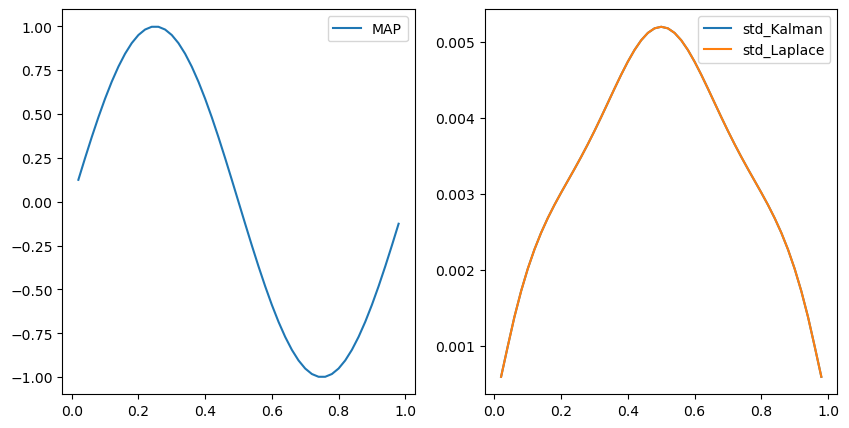

PyObject <matplotlib.legend.Legend object at 0x7f01041e84c0>

In [87]:
fig_approx = figure(figsize=(10,5))
subplot(121)
plot(X_domain, MAP, label = "MAP")
legend()
subplot(122)
plot(X_domain, sol_std_Kalman, label = "std_Kalman")
plot(X_domain, sol_std, label = "std_Laplace")
legend()

In [7]:
# test convergence in the Gaussian case

# emcee_ite = 10^3
# log_post, hessian_log_post = hessian_log_post_GP_PDE(eqn, cov, X_domain, X_boundary; nugget = 1e-14)
# ensemble_size = 20*N_domain
# θ0 = zeros(ensemble_size, N_domain)
# for i in 1:ensemble_size
#     θ0[i,:] = MAP + rand(Normal(0,1), N_domain)
# end

# for it in 1:100
#     emcee_samples = emcee_Run(log_post, θ0, emcee_ite*it)
#     std_emcmc = std(emcee_samples[emcee_ite÷4:end,:,:], dims=[1,2])
#     println(mean(abs.(std_emcmc[:] .- sol_std)./abs.(sol_std)))
#     mean_emcmc = mean(emcee_samples[emcee_ite÷4:end,:,:], dims=[1,2])
#     println(mean(abs.(mean_emcmc[:] .- MAP)./abs.(MAP)))
#     flush(stdout)
# end

In [71]:
emcee_ite = 10^5
log_post, hessian_log_post = hessian_log_post_GP_PDE(eqn, cov, X_domain, X_boundary; nugget = 1e-14)
ensemble_size = 4*N_domain
θ0 = zeros(ensemble_size, N_domain)
for i in 1:ensemble_size
    θ0[i,:] = MAP + rand(Normal(0,1), N_domain)
end
emcee_samples = emcee_Run(log_post, θ0, emcee_ite)

LoadError: InterruptException:

In [68]:
mean_emcmc = mean(emcee_samples[emcee_ite÷4:end,:,:], dims=[1,2])
# std_emcmc = std(emcee_samples[emcee_ite÷4:end,:,:], dims=[1,2])
moments_emcmc = mean(emcee_samples[emcee_ite÷4:end,:,:].^2, dims=[1,2])
moments_Gaussian = sol_std.^2 + MAP.^2
println(sum(abs.(moments_emcmc[:]-moments_Gaussian))./sum(abs.(moments_Gaussian)))
# println(sum(abs.(std_emcmc[:] .- sol_std))./sum(abs.(sol_std)))
println(sum(abs.(mean_emcmc[:] .- MAP))./sum(abs.(MAP)))

0.1003913487653271
0.05605578884588779


In [70]:
moments_emcmc[:] - moments_Gaussian

49-element Vector{Float64}:
 -0.012452609280433945
 -0.022928184998565616
 -0.007037903130982126
  0.04492019767322092
  0.06771801206038697
  0.0743646662917053
  0.1209179281776247
  0.1405408845162175
  0.08161988513332985
 -0.017672658561338705
 -0.05535564798529513
 -0.004869494974897304
  0.07987516828763974
  ⋮
 -0.044453999146146006
 -0.08090466124855455
 -0.10990664990711307
 -0.09884698072815856
 -0.06557079447951641
 -0.058477998297829625
 -0.033187302072271274
 -0.010546219789603295
 -0.0008700242748441722
  0.008360176275988146
  0.01388276822787636
  0.013006785919406027

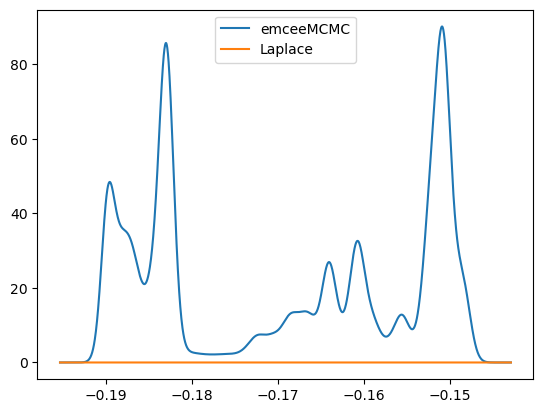

PyObject <matplotlib.legend.Legend object at 0x7efd50fae3a0>

In [64]:
idx = N_domain
kde_data = reshape(emcee_samples[emcee_ite÷4:end,:,idx], prod(size(emcee_samples[emcee_ite÷4:end,:,idx])))
emcee_density_mcmc = kde(kde_data)
plot(emcee_density_mcmc.x,emcee_density_mcmc.density, label = "emceeMCMC")
# sns.kdeplot(data[:,0], ax=axs[0], label='truth', color='black', log_scale=(0,10))

gmean = MAP[idx]
gstd = sol_std[idx]
x = emcee_density_mcmc.x
density_gaussian_y = 1/(sqrt(2*pi)*gstd)*exp.(-(x.-gmean).^2/(2*gstd^2))
plot(x, density_gaussian_y, label = "Laplace")
legend()